## **REFERENCE FULL ORDER PROBLEM**

#### LOAD LIBRARIES

In [1]:
# Pulizia
from IPython import get_ipython
get_ipython().magic('clear')
get_ipython().magic('reset -f')

# Import libraries:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
from scipy.sparse.linalg import splu
from scipy.linalg import lu_factor
import itertools
import time
import os
import sys
import json
import pandas as pd

# Import user defined libraries:
from FreeFEM import FFmatrix_fread, FFvector_fread

/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_4516/1511052661.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('clear')
/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_4516/1511052661.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


## **Full order**

#### DEFINE REFERENCE PROBLEM PARAMETERS

In [2]:
with open("reference case/Reference_parameters.json", "r") as json_file:
    parameters = json.load(json_file)

N_AVOG = parameters["N_AVOG"]  
N_BOLT = parameters["N_BOLT"]  
FISSION_ENERGY = parameters["FISSION_ENERGY"]                       
FISSION_RATE = parameters["FISSION_RATE"]                   
RADIUS = parameters["RADIUS"]
LENGTH = parameters["LENGTH"]
FISSION_YIELD = parameters["FISSION_YIELD"]                 
FUEL_THERMAL_CONDUCTIVITY = parameters["FUEL_THERMAL_CONDUCTIVITY"]
T_BC = parameters["T_BC"]  
C_BC = parameters["C_BC"]  

SOURCE_C = FISSION_RATE * FISSION_YIELD         #[atm / (m^3 s)]
GAMMA_T = (FISSION_RATE * FISSION_ENERGY * LENGTH**2)/(FUEL_THERMAL_CONDUCTIVITY)

      
# Define reference temperature, concentration and linear diffusion parameters:
T_IC  = T_BC # [K]
C_IC = C_BC  # [atm / m^3]
 

# Define final time, time increment:
TIME_FINAL = 1.00E+07  # [s]
TIME_DELTA = 1.00E+04  # [s]

# Compute number of iterations:
N_ITER = int(TIME_FINAL / TIME_DELTA)  # [-]

# Define function evaluating the concentration diffusion coefficient at given z coordinated provided the problem parameters:
def ALPHA_C(ZZ, T_BC=T_BC, GAMMA_T=GAMMA_T, FISSION_RATE=FISSION_RATE):
    return 7.60E-10 * np.exp(- 4.86E-19 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2) / N_BOLT) + \
           5.64E-25 * np.exp(- 1.91E-19 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2) / N_BOLT) * np.sqrt(FISSION_RATE) + \
           8.00E-40 * FISSION_RATE

(1001, 6)


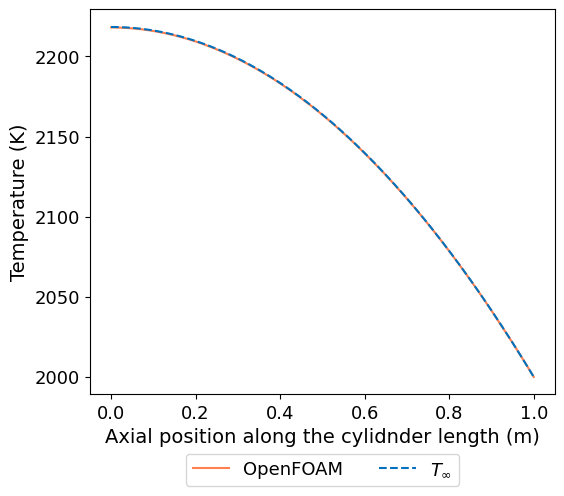

In [ ]:
OpenFOAM=pd.read_csv("data/OpenFOAM_Tprofile.csv")     

fig, (ax1) = plt.subplots(1, figsize=(6,5))
ax1.plot(OpenFOAM.iloc[:, -1], OpenFOAM.iloc[:, 0], label = 'OpenFOAM', color='#FF7F50', linewidth=1.5)
ax1.plot(np.linspace(0, 1,1000), T_BC + GAMMA_T * (1 - np.linspace(0, 1,1000)**2) / 2, '--',label = '$T_\infty$', color='#0072bd', linewidth=1.5)

ax1.tick_params(axis="y", labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax1.ticklabel_format(useOffset=False)
ax1.set_xlabel('Axial position along the cylidnder length (m)',fontsize=14)
ax1.set_ylabel('Temperature (K)',fontsize=14)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=2, fontsize=13)

#errore_end= (np.abs((OpenFOAM[-1,1]- (T_BC + GAMMA_T * (1 - np.linspace(0, 1,1000)**2) / 2)))/(OpenFOAM[-1,1]))*100
#print(rf'Relative error (@ final time): {errore_end:.5f}%')
print(OpenFOAM.shape)
print()

#### IDENTIFY DIRICHLET DOFS AND INTERNAL DOFS

In [4]:
# Load coordinates:
coordinates_Px = FFvector_fread('mesh_utilities/vv_cc_Px.btxt')
coordinates_Pq = FFvector_fread('mesh_utilities/vv_cc_Pq.btxt')

# Identify degrees of freedom of the Px and Pq spaces:
sFO_Px = coordinates_Px.shape[0]
sFO_Pq = coordinates_Pq.shape[0]
print(rf'Degree of freedom = {sFO_Px}')

# Define vector of all Px indeces:
mask_all = np.arange(sFO_Px, dtype=int)

# Identify indeces of the top, bottom and middle boundaries in Px:
mask_inf_bc = mask_all[np.isclose([coordinates_Px[ii, 1] for ii in range(sFO_Px)], np.zeros((sFO_Px)))]
mask_sup_bc = mask_all[np.isclose([coordinates_Px[ii, 1] for ii in range(sFO_Px)], np.ones((sFO_Px)))]
mask_mid_bc = mask_all[np.isclose([coordinates_Px[ii, 0] for ii in range(sFO_Px)], np.zeros((sFO_Px)))]
mask_ext_bc = mask_all[np.isclose([coordinates_Px[ii, 0] for ii in range(sFO_Px)], np.ones((sFO_Px)))]

# Identify indeces of the Dirichlet b.c. for the temperature and concentration field:
mask_bc_T = np.fromiter(set(mask_sup_bc), int)
mask_bc_C = np.fromiter(set(mask_sup_bc) | set(mask_ext_bc) | set(mask_inf_bc), int)

# Identify indeces of the interior for the temperature and concentration field:
mask_in_T = [ii for ii in mask_all if ii not in mask_bc_T]
mask_in_C = [ii for ii in mask_all if ii not in mask_bc_C]

Degree of freedom = 10201


#### DEFINE FINITE ELEMENT ESSENTIALS

In [5]:
# Import mass matrices on the Px and on the Pq space:
mass_Px = FFmatrix_fread('mesh_utilities/ww_mm_Px.btxt')
mass_Pq = FFmatrix_fread('mesh_utilities/ww_mm_Pq.btxt')
mass_Pm = FFmatrix_fread('mesh_utilities/ww_uu_Px_Pq.btxt')

# Extract integration weights and diagonal matrix with their inverse:
weights_Pq = mass_Pq.diagonal()
project_Pq = sparse.diags(np.reciprocal(weights_Pq))

# Import map from Px to Pq and to the dx, dy, dz derivative evaluated in Pq:
PxtoPquu_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_uu_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdx_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_dx_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdy_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_dy_Px_Pq.btxt')[:, mask_in_C])

# Define weights for the integration in polar coordinates:
polar_weights_Pq = np.multiply(coordinates_Pq[:, 0], weights_Pq)

# Compute volume of the domain:
volume = np.dot(np.ones(sFO_Pq), polar_weights_Pq)

# Assemble mass matrix and projected forcing term:
forc_C = PxtoPquu_C.T.dot(polar_weights_Pq[:, None])
mass_C = PxtoPquu_C.T.dot(PxtoPquu_C.multiply(polar_weights_Pq[:, None]))
inte_C = PxtoPquu_C.T.dot(polar_weights_Pq) / volume

# Assemble a function assembling the stiffness matrix at a given time:
stiff_C = PxtoPqdx_C.T.dot(PxtoPqdx_C.multiply(ALPHA_C(coordinates_Pq[:, 1:2]) / RADIUS**2 * polar_weights_Pq[:, None])) + \
          PxtoPqdy_C.T.dot(PxtoPqdy_C.multiply(ALPHA_C(coordinates_Pq[:, 1:2]) / LENGTH**2 * polar_weights_Pq[:, None]))

#### IMPLEMENT FULLY IMPLICID FORWARD EULER FOR THE CONCENTRATION ONLY

In [6]:
# Initialise temperature and concentration solution containing the deviation from the initial condition:
sol_new_C = np.zeros((sFO_Px, N_ITER+1)) 
average_C = np.zeros(N_ITER)  

lhs_static = mass_C + TIME_DELTA * stiff_C
lhs_static = lhs_static.toarray()             #--> NECESSARIO PER LU MA NON PER BICGSTAB
rhs_static = TIME_DELTA * (SOURCE_C * forc_C)
LU, PIV = sp.linalg.lu_factor(lhs_static)

#Integrate using forward Euler up to the final time:
for ii in range(N_ITER):
    cur_time = ii * TIME_DELTA

    # Print current iteration and average temperature and concentration:
    print('Current time:', cur_time, 's')
    average_C[ii] = inte_C @ sol_new_C[mask_in_C, ii]
    print('Average concentration:', average_C[ii], 'atm/m^3\n')
    
    # Assemble current left-hand-side and right-hand-side
    #cur_lhs = mass_C + TIME_DELTA * stiff_C
    #cur_rhs = mass_C.dot(sol_new_C[mask_in_C, ii:ii+1]) + TIME_DELTA * (SOURCE_C * forc_C)
    cur_rhs = mass_C.dot(sol_new_C[mask_in_C, ii:ii+1]) + rhs_static
    
    # Compute perturbation from the initial temperature and concentration in the interior of the domain:
    #sol_new_C[mask_in_C, ii+1], _ = linalg.bicgstab(lhs_static, cur_rhs)       # --> OLD SOLVER
    sol_new_C[mask_in_C, ii+1] = sp.linalg.lu_solve((LU, PIV), cur_rhs[:,0])
    

# Print final time and final average temperature and concentration:
print('Final time:', N_ITER * TIME_DELTA, 's')
average_C[ii] = inte_C @ sol_new_C[mask_in_C, ii]
print('Average concentration:', inte_C @ sol_new_C[mask_in_C, -1], 'atm/m^3')

Current time: 0.0 s
Average concentration: 0.0 atm/m^3

Current time: 10000.0 s
Average concentration: 6.0782449308798684e+22 atm/m^3

Current time: 20000.0 s
Average concentration: 1.1626510187445945e+23 atm/m^3

Current time: 30000.0 s
Average concentration: 1.679052346217632e+23 atm/m^3

Current time: 40000.0 s
Average concentration: 2.1643459522707717e+23 atm/m^3

Current time: 50000.0 s
Average concentration: 2.6231233594651695e+23 atm/m^3

Current time: 60000.0 s
Average concentration: 3.05861145047327e+23 atm/m^3

Current time: 70000.0 s
Average concentration: 3.473240584859418e+23 atm/m^3

Current time: 80000.0 s
Average concentration: 3.86892904465962e+23 atm/m^3

Current time: 90000.0 s
Average concentration: 4.24724321432947e+23 atm/m^3

Current time: 100000.0 s
Average concentration: 4.6094955474076055e+23 atm/m^3

Current time: 110000.0 s
Average concentration: 4.956808266680278e+23 atm/m^3

Current time: 120000.0 s
Average concentration: 5.290156781913806e+23 atm/m^3

Cur

In [7]:
np.savetxt('data/Fullorder_Cfield.csv', sol_new_C[:, :], delimiter=',', fmt='%d')         #Salvo il campo di concentrazione ad ogni istante di tempo
np.savetxt('data/Fullorder_Caverage.csv', average_C[:], delimiter=',', fmt='%d')          #Salvo la concentrazione media ad ogni istante di tempo

OpenFOAM average concentration (@ final time): 1.660453e+24 atm/m^3
Python average concentration (@ final time): 1.6440833674866712e+24 atm/m^3
Relative error (@ final time): 0.98585%
Relative error (@ final time) with model 3D: 0.64117%


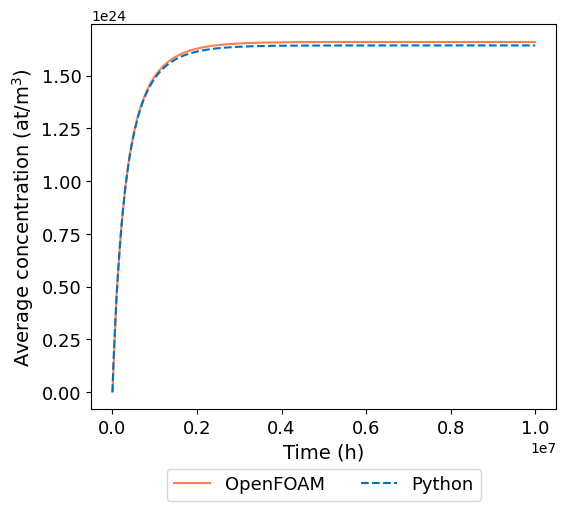

In [8]:
sol_new_C = np.loadtxt('data/Fullorder_Cfield.csv', delimiter=',')
OpenFOAM=np.loadtxt("data/OpenFOAM_Caverage.dat")    
print('OpenFOAM average concentration (@ final time):', OpenFOAM[-1,1], 'atm/m^3')

model_3d = pd.read_csv("/Users/martina/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Git/rom-cylinder_DEIM-POD/offline-online stages/model_3d/Turnbull/0. full order/sensitivity/10Layers_5Refine_0.75Transition_4Center.csv")

time = np.linspace(0, 1e7, sol_new_C.shape[1])
cmap = plt.get_cmap('RdBu')
color = cmap(0.9)

fig, (ax1) = plt.subplots(1,  figsize=[6,5])
ax1.plot(OpenFOAM[:,0],OpenFOAM[:,1], color='#FF7F50', label='OpenFOAM', linewidth=1.5)
ax1.plot(time, inte_C @ sol_new_C[mask_in_C, :], '--',color='#0072bd', label='Python', linewidth=1.5)
#ax1.plot(model_3d['Time (s)'], model_3d['Average dC (atm/m^3)'], color='#050402', label='Python', linewidth=1.5)
ax1.set_xlabel('Time (h)', fontsize=14)
ax1.set_ylabel('Average concentration (at/m$^3$)',fontsize=14)
ax1.tick_params(axis="x", labelsize=13)
ax1.tick_params(axis="y", labelsize=13)

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=2, fontsize=13)

print('Python average concentration (@ final time):', inte_C @ sol_new_C[mask_in_C, -1], 'atm/m^3')
errore_end= (np.abs((OpenFOAM[-1,1]-inte_C @ sol_new_C[mask_in_C, -1]))/(OpenFOAM[-1,1]))*100
print(rf'Relative error (@ final time): {errore_end:.5f}%')

errore_end= (np.abs((model_3d['Average dC (atm/m^3)'].iloc[-1]-inte_C @ sol_new_C[mask_in_C, -1]))/(model_3d['Average dC (atm/m^3)'].iloc[-1]))*100
print(rf'Relative error (@ final time) with model 3D: {errore_end:.5f}%')

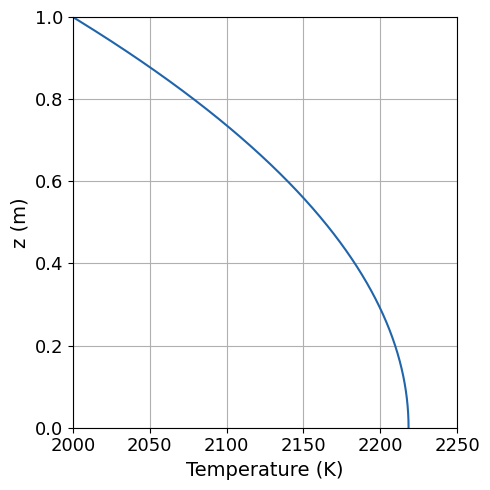

In [ ]:
# Lettura dei parametri di riferimento dal file JSON
with open("data/Reference_parameters.json", "r") as json_file:
    parameters = json.load(json_file)
FISSION_ENERGY = parameters["FISSION_ENERGY"]                       
FISSION_RATE = parameters["FISSION_RATE"]                   
LENGTH = parameters["LENGTH"]               
FUEL_THERMAL_CONDUCTIVITY = parameters["FUEL_THERMAL_CONDUCTIVITY"]
T_BC = parameters["T_BC"]  
GAMMA_T = (FISSION_RATE * FISSION_ENERGY * LENGTH**2)/(FUEL_THERMAL_CONDUCTIVITY)

#OpenFOAM=pd.read_csv("data/Temperature_along_z.csv")     

cmap = plt.get_cmap('RdBu')
color = cmap(0.9)

total_layers = list(set(coordinates_Px[:,1]))
all_layers = sorted(list(set(coordinates_Px[:, 1])))
effective_layers = np.linspace(all_layers[0], all_layers[-1], 5)  # Livelli da etichettare


fig, (ax1) = plt.subplots(1, figsize=(5,5))
#ax1.plot(OpenFOAM.iloc[:, -1], OpenFOAM.iloc[:, 0], label = 'OpenFOAM', color='#FF7F50', linewidth=1.5)
ax1.plot( T_BC + GAMMA_T * (1 - np.linspace(0,1 ,1001)**2) / 2, np.linspace(0,1,1001), label = '$T_\infty$', color=color, linewidth=1.5)
ax1.tick_params(axis="y", labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax1.ticklabel_format(useOffset=False)
#ax1.set_yticks(all_layers)  # Mostra tutti i tick
#ax1.set_yticklabels(
#    [f"{layer:.2f}" if layer in effective_layers else "" for layer in all_layers],
#    fontsize=13
#)  # Etichetta solo i livelli scelti, lasciando vuoti gli altri

ax1.set_ylim([0, 1])
ax1.set_xlim([2000, 2250])
ax1.set_ylabel('z (m)',fontsize=14)
ax1.set_xlabel('Temperature (K)',fontsize=14)
ax1.grid()
plt.tight_layout()
plt.savefig('plot/Temperature profile.pdf', bbox_inches='tight') 

#ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=2, fontsize=13)

#error = ((np.abs((OpenFOAM.iloc[:, 0]-(T_BC + GAMMA_T * (1 - np.linspace(0, 1,1001)**2) / 2))))/OpenFOAM.iloc[:, 0])*100
#print(np.max(error))

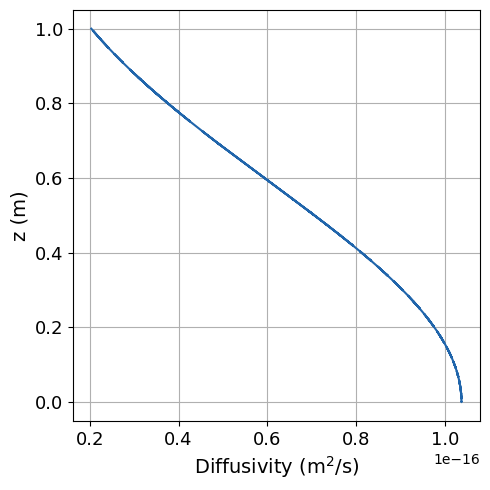

In [15]:
# Lettura dei parametri di riferimento dal file JSON
with open("reference case/Reference_parameters.json", "r") as json_file:
    parameters = json.load(json_file)
FISSION_ENERGY = parameters["FISSION_ENERGY"]                       
FISSION_RATE = parameters["FISSION_RATE"]                   
LENGTH = parameters["LENGTH"]               
FUEL_THERMAL_CONDUCTIVITY = parameters["FUEL_THERMAL_CONDUCTIVITY"]
T_BC = parameters["T_BC"]  
GAMMA_T = (FISSION_RATE * FISSION_ENERGY * LENGTH**2)/(FUEL_THERMAL_CONDUCTIVITY)

def ALPHA_C(ZZ, T_BC=T_BC, GAMMA_T=GAMMA_T, FISSION_RATE=FISSION_RATE):
    return 7.60E-10 * np.exp(- 4.86E-19 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2) / N_BOLT) + \
           5.64E-25 * np.exp(- 1.91E-19 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2) / N_BOLT) * np.sqrt(FISSION_RATE) + \
           8.00E-40 * FISSION_RATE

cmap = plt.get_cmap('RdBu')
color = cmap(0.9)

total_layers = list(set(coordinates_Px[:,1]))
all_layers = sorted(list(set(coordinates_Px[:, 1])))
effective_layers = np.linspace(all_layers[0], all_layers[-1], 5)  # Livelli da etichettare


fig, (ax1) = plt.subplots(1, figsize=(5,5))
ax1.plot( ALPHA_C(coordinates_Pq[:, 1:2]), coordinates_Pq[:, 1:2], label = '$T_\infty$', color=color, linewidth=1.5)
ax1.tick_params(axis="y", labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax1.ticklabel_format(useOffset=False)

#ax1.set_ylim([0, 1])
#ax1.set_xlim([2000, 2250])
ax1.set_ylabel('z (m)',fontsize=14)
ax1.set_xlabel(rf'Diffusivity (m$^2$/s)',fontsize=14)
ax1.grid()
plt.tight_layout()
plt.savefig('plot/Temperature profile.pdf', bbox_inches='tight') 

#ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=2, fontsize=13)

#error = ((np.abs((OpenFOAM.iloc[:, 0]-(T_BC + GAMMA_T * (1 - np.linspace(0, 1,1001)**2) / 2))))/OpenFOAM.iloc[:, 0])*100
#print(np.max(error))

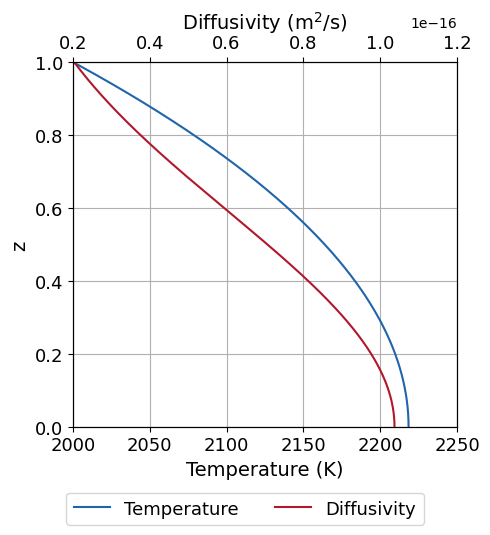

In [3]:
# Lettura dei parametri di riferimento dal file JSON
with open("reference case/Reference_parameters.json", "r") as json_file:
    parameters = json.load(json_file)

FISSION_ENERGY = parameters["FISSION_ENERGY"]                       
FISSION_RATE = parameters["FISSION_RATE"]                   
LENGTH = parameters["LENGTH"]               
FUEL_THERMAL_CONDUCTIVITY = parameters["FUEL_THERMAL_CONDUCTIVITY"]
T_BC = parameters["T_BC"]  
GAMMA_T = (FISSION_RATE * FISSION_ENERGY * LENGTH**2)/(FUEL_THERMAL_CONDUCTIVITY)

N_BOLT = 1.380649e-23  # Costante di Boltzmann

def ALPHA_C(ZZ, T_BC=T_BC, GAMMA_T=GAMMA_T, FISSION_RATE=FISSION_RATE):
    return 7.60E-10 * np.exp(- 4.86E-19 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2) / N_BOLT) + \
           5.64E-25 * np.exp(- 1.91E-19 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2) / N_BOLT) * np.sqrt(FISSION_RATE) + \
           8.00E-40 * FISSION_RATE

# Coordinate per il calcolo
z = np.linspace(0, 1, 1001)  # Generazione di coordinate lungo z
temperature = T_BC + GAMMA_T * (1 - z**2) / 2
diffusivity = ALPHA_C(z)

# Creazione del grafico
fig, ax1 = plt.subplots(figsize=(5,5))

cmap = plt.get_cmap('RdBu')
color = cmap(0.9)

# Plot della temperatura
ax1.plot(temperature, z, label='Temperature', color=color, linewidth=1.5)
ax1.set_xlabel('Temperature (K)', fontsize=14)
ax1.set_ylabel('z', fontsize=14)
ax1.tick_params(axis='x', labelsize=13, colors='black')
ax1.tick_params(axis='y', labelsize=13, colors='black')
ax1.grid()
ax1.set_xlim(2000, 2250)
ax1.set_ylim(0, 1)

color = cmap(0.1)
# Asse per la diffusività
ax2 = ax1.twiny()  # Creazione di un asse X superiore
ax2.plot(diffusivity, z, label=r'Diffusivity', color= color, linewidth=1.5)
ax2.set_xlabel(r'Diffusivity (m$^2$/s)', fontsize=14)
ax2.tick_params(axis='x', labelsize=13, colors='black')
ax2.set_xlim(0.2e-16, 1.2e-16)

# Legenda in basso
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
fig.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower center', bbox_to_anchor=(0.5, -0.08), ncol=2, fontsize=13)

# Layout e salvataggio
plt.tight_layout()
plt.savefig('plot/Temperature and diffusivity profiles.pdf', bbox_inches='tight')
plt.show()